# 2022 Dev in AI Final Project
Carl Barcenas

## 1. Load Libraries and Create Data Loading Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math
import autogluon
import statistics
import sys
import os
import copy
import scipy.io
import zipfile

In [2]:
# Data Path
path = os.path.join(os.path.abspath('.'), 'Data\\Data_Public')

# Function to read PLC data
def read_plc_data(path, dataset):
    data_path = path + '/' + dataset + '.zip'
    zf = zipfile.ZipFile(data_path)
    plc_df = pd.read_csv(zf.open(dataset + '/PLC/plc.csv'))
    return plc_df
    
# Function to read sensor data
def read_sensor_data(path, dataset, csv_no):
    data_path = path + '/' + dataset + '.zip'
    zf = zipfile.ZipFile(data_path)
    sensor_df = pd.read_csv(zf.open(dataset + '/Sensor/' + str(csv_no)+'.csv'))
    return sensor_df

## 2. Creating Training Data Set 1

### PLC Data

In [3]:
# Function to convert h:m:s:ms format of PLC data to minutes (float)
def convert_to_minutes(df):
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S:%f') # Convert data to datetime
    df['time'] = df['time'].apply(lambda x: x.hour*60 + x.minute +  # Convert datetime to minutes
                                          (x.second / 60) + (x.microsecond / 60000000))

# Function to calculate RUL
def calculate_rul(df):
    # Get initial RUL
    rul = [df['time'].iloc[-1] - df['time'].iloc[0]]
    
    # Calculate RUL over time and append as a column
    for x in range(len(df)-1):
        delta_time = df['time'].iloc[x+1] - df['time'].iloc[x]
        rul.append(rul[x]-delta_time)
        
    df['rul'] = rul

In [4]:
# Function to normalize time gaps in dataframe
def normalize_time_gaps(df):
    max_idx = []
    time_gaps = []
    
    # Getting indexes of final index within a csv_no range
    for i in range(1, df['csv_no'].max()):
        temp = df.loc[df['csv_no'] == i]
        max_idx.append(temp.index[-1])
        
    # Finding time gaps between csv_no's
    for i in range(len(max_idx)-1):
        time_gaps.append(df['time'].iloc[max_idx[i+1]] - df['time'].iloc[max_idx[i]])
        
    # Get median time gap value
    avg_time_gap = statistics.median(time_gaps)
    
    # Find all occurrences where time gap is significantly above average
    time_gaps_above_average = [i for i in time_gaps if i >= (avg_time_gap + 2.5)]
    
    # Find which csvs these belong to and find their max indexes
    idx_tg = []
    idx_plc = []
    delta_time = []

    for i in time_gaps_above_average: # Calculating how much to subtract from time to normalize
        delta_time.append(abs(avg_time_gap - i))
        
    for i in time_gaps_above_average:
        idx_tg.append(time_gaps.index(i))
        
    for i in idx_tg:
        idx_plc.append(max_idx[i])    
        
    # Make changes to dataframe. (df[max_idx:end] -= delta_time)
    for i in range(len(idx_plc)):
        df['time'].iloc[idx_plc[i]+1:(len(plc_1_df))] = df['time'].iloc[idx_plc[i]+1:len(df)] - delta_time[i]

C:\Users\carlb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


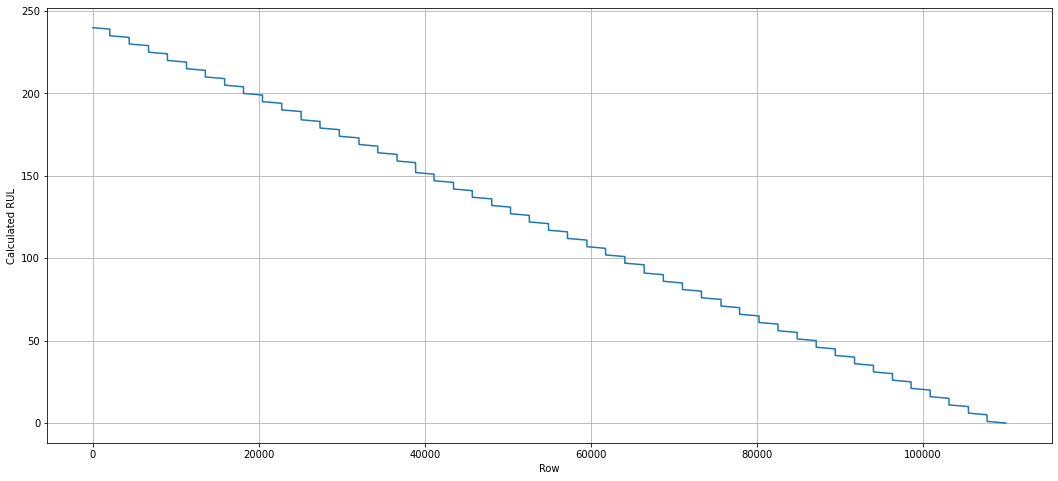

In [5]:
# Load PLC Data and convert time format
plc_1_df = read_plc_data(path, 'Training Data-01')
convert_to_minutes(plc_1_df)
calculate_rul(plc_1_df)
normalize_time_gaps(plc_1_df)
calculate_rul(plc_1_df)

# Plot the data to analyze
plt.figure(figsize=(18,8))
plt.xlabel('Row')
plt.ylabel('Calculated RUL')
plt.grid()
plt.plot(range(len(plc_1_df)), plc_1_df['rul'])

In [6]:
plc_1_df

,time,spindle_load,x,y,z,csv_no,rul
0,688.118783,0.082400,-20.9572,-17.6915,-89.6468,1,239.879417
1,688.118950,0.082400,-20.9572,-17.6915,-89.6468,1,239.879250
2,688.119117,0.082400,-20.9572,-17.6915,-89.6468,1,239.879083
3,688.119283,0.082400,-20.9572,-17.6915,-89.6468,1,239.878917
4,688.119450,0.082400,-20.9572,-17.6915,-89.6468,1,239.878750
...,...,...,...,...,...,...,...
110022,927.995033,0.006104,-1.1088,-201.1264,-86.2070,48,0.003167
110023,927.995200,0.006104,-1.1088,-201.1264,-86.2070,48,0.003000
110024,927.997867,0.006104,-1.1088,-201.1264,-86.2070,48,0.000333
110025,927.998033,0.006104,-1.1088,-201.1264,-86.2070,48,0.000167


### Sensor Data

Create functions for Sensor Data

In [7]:
# Segment single csv sensor data into parts. Helper function of following function
def segment_sensor_data(sensor_df, plc_df):
    # Create placeholder arrays
    vibration_1 = []
    vibration_2 = []
    vibration_3 = []
    current = []
    csv_no = []
    
    # Determine segment indexes
    # segment_size = math.floor(len(sensor_df) / 2293)
    segment_size = math.floor(len(sensor_df) / math.ceil(len(plc_df) / plc_df['csv_no'].max()))
    start_seg_idx = 0
    end_seg_idx = start_seg_idx + segment_size
    
    # For 2293 segments, get the mean of each segment and store data
    for i in range(2293):
        vibration_1.append(sensor_df.iloc[start_seg_idx:end_seg_idx]['vibration_1'].mean())
        vibration_2.append(sensor_df.iloc[start_seg_idx:end_seg_idx]['vibration_2'].mean())
        vibration_3.append(sensor_df.iloc[start_seg_idx:end_seg_idx]['vibration_3'].mean())
        current.append(sensor_df.iloc[start_seg_idx:end_seg_idx]['current'].mean())
        
        # Increment to next set of rows for next segment
        start_seg_idx = end_seg_idx
        end_seg_idx += segment_size
    
    # Create and return new dataframe of segmented means
    data = {'vibration_1': vibration_1,
             'vibration_2': vibration_2,
             'vibration_3': vibration_3,
             'current': current}
    new_df = pd.DataFrame(data)
    
    return new_df

# Function to load sensor csvs and then segment.
def segment_and_merge(plc_df, dataset):
    sensor_df = pd.DataFrame()
    
    # Looping through all csv's in dataset
    for csv_no in range(1, plc_df['csv_no'].max() + 1):
        temp_df = read_sensor_data(path, dataset, 1)
        temp_df = segment_sensor_data(temp_df, plc_df)
        sensor_df = sensor_df.append(temp_df, ignore_index=True)
    return sensor_df

In [8]:
sensor_df = segment_and_merge(plc_1_df, 'Training Data-01')
sensor_df

,vibration_1,vibration_2,vibration_3,current
0,0.032409,-0.011581,0.043371,-31.992161
1,0.030038,-0.010055,0.043393,-31.960397
2,0.031547,-0.007687,0.036908,-31.971642
3,0.032493,-0.007762,0.031924,-31.959100
4,0.034486,-0.008416,0.030639,-31.952006
...,...,...,...,...
110059,0.191559,-0.029594,0.045753,2.116159
110060,0.057930,-0.020419,-0.031398,-3.283798
110061,-0.030110,-0.009590,-0.080127,3.340704
110062,0.035144,-0.028905,-0.006661,-4.091687


### Merge Sensor and PLC Data

In [9]:
final_train_set_1 = plc_1_df.join(sensor_df)
final_train_set_1

,time,spindle_load,x,y,z,csv_no,rul,vibration_1,vibration_2,vibration_3,current
0,688.118783,0.082400,-20.9572,-17.6915,-89.6468,1,239.879417,0.032409,-0.011581,0.043371,-31.992161
1,688.118950,0.082400,-20.9572,-17.6915,-89.6468,1,239.879250,0.030038,-0.010055,0.043393,-31.960397
2,688.119117,0.082400,-20.9572,-17.6915,-89.6468,1,239.879083,0.031547,-0.007687,0.036908,-31.971642
3,688.119283,0.082400,-20.9572,-17.6915,-89.6468,1,239.878917,0.032493,-0.007762,0.031924,-31.959100
4,688.119450,0.082400,-20.9572,-17.6915,-89.6468,1,239.878750,0.034486,-0.008416,0.030639,-31.952006
...,...,...,...,...,...,...,...,...,...,...,...
110022,927.995033,0.006104,-1.1088,-201.1264,-86.2070,48,0.003167,0.154097,-0.007788,-0.050659,-4.969523
110023,927.995200,0.006104,-1.1088,-201.1264,-86.2070,48,0.003000,0.057896,-0.024258,0.022523,3.895022
110024,927.997867,0.006104,-1.1088,-201.1264,-86.2070,48,0.000333,-0.011692,-0.032147,-0.005117,-4.577046
110025,927.998033,0.006104,-1.1088,-201.1264,-86.2070,48,0.000167,-0.069788,0.005347,-0.046505,3.548467


## 3. Creating Training Dataset 2

In [10]:
# Load and Format the data using functions above
train_plc_2_df = read_plc_data(path, 'Training Data-02')
convert_to_minutes(train_plc_2_df)
normalize_time_gaps(train_plc_2_df)
calculate_rul(train_plc_2_df)
train_sensor_2_df = segment_and_merge(train_plc_2_df, 'Testing Data-02')
final_train_set_2 = train_plc_2_df.join(train_sensor_2_df)
final_train_set_2

C:\Users\carlb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,time,spindle_load,x,y,z,csv_no,rul,vibration_1,vibration_2,vibration_3,current
0,582.015667,0.061037,-83.7938,-182.5368,0.0000,1,236.902417,0.053422,-0.011271,0.052143,3.477938
1,582.001733,0.061037,-83.7938,-182.5368,0.0000,1,236.916350,0.024939,0.014522,0.003076,-3.126718
2,582.001900,0.061037,-83.7938,-182.5368,0.0000,1,236.916183,-0.006256,-0.016111,-0.021719,-0.383739
3,582.002067,0.061037,-83.7938,-182.5368,0.0000,1,236.916017,0.033120,-0.030352,0.056900,2.105983
4,582.002233,0.061037,-83.7938,-182.5368,0.0000,1,236.915850,0.051437,0.027488,0.009682,-4.610902
...,...,...,...,...,...,...,...,...,...,...,...
107834,818.917417,4.043703,-344.5079,394.5867,-421.4568,48,0.000667,-0.006010,0.013534,-0.025405,0.575362
107835,818.917583,4.043703,-344.5079,394.5867,-421.4568,48,0.000500,0.018035,-0.030166,0.032814,1.486338
107836,818.917750,4.043703,-344.5079,394.5867,-421.4568,48,0.000333,0.061073,-0.007262,0.049421,-4.144753
107837,818.917917,4.043703,-344.5079,394.5867,-421.4568,48,0.000167,0.013793,0.000963,-0.010541,3.773475


## 4. Creating Final Train Set (Check NaN and Merge)

In [11]:
# Create a function to check if the set has any NA vals
def check_na_vals(df):
    columns = ['spindle_load', 'x', 'y', 'z', 'vibration_1', 'vibration_2', 'vibration_3', 'current']
    for i in columns:
        print(i + ': ' + str(df[i].isna().sum()))
        
print('Train Set 1')
check_na_vals(final_train_set_1)

print('\nTrain Set 2')
check_na_vals(final_train_set_2)

Train Set 1
spindle_load: 0
x: 0
y: 0
z: 0
vibration_1: 0
vibration_2: 0
vibration_3: 0
current: 0

Train Set 2
spindle_load: 0
x: 0
y: 0
z: 0
vibration_1: 2115
vibration_2: 2115
vibration_3: 2115
current: 2115


In [12]:
# Notice that Train Set 2 has NA Values, thus we will fill them with an imputer
from sklearn.impute import SimpleImputer

final_train = final_train_set_1.append(final_train_set_2, ignore_index=True)

imputer = SimpleImputer(missing_values=math.nan, strategy='most_frequent')
final_train_set_2.vibration_1 = imputer.fit_transform(final_train_set_2['vibration_1'].values.reshape(-1,1))[:, 0]
final_train_set_2.vibration_2 = imputer.fit_transform(final_train_set_2['vibration_2'].values.reshape(-1,1))[:, 0]
final_train_set_2.vibration_3 = imputer.fit_transform(final_train_set_2['vibration_3'].values.reshape(-1,1))[:, 0]
final_train_set_2.current = imputer.fit_transform(final_train_set_2['current'].values.reshape(-1,1))[:, 0]

# Now that NaN values filled, stack training sets together.
final_train_imputed = final_train_set_1.append(final_train_set_2, ignore_index=True)

In [13]:
# final_train_imputed
final_train

,time,spindle_load,x,y,z,csv_no,rul,vibration_1,vibration_2,vibration_3,current
0,688.118783,0.082400,-20.9572,-17.6915,-89.6468,1,239.879417,0.032409,-0.011581,0.043371,-31.992161
1,688.118950,0.082400,-20.9572,-17.6915,-89.6468,1,239.879250,0.030038,-0.010055,0.043393,-31.960397
2,688.119117,0.082400,-20.9572,-17.6915,-89.6468,1,239.879083,0.031547,-0.007687,0.036908,-31.971642
3,688.119283,0.082400,-20.9572,-17.6915,-89.6468,1,239.878917,0.032493,-0.007762,0.031924,-31.959100
4,688.119450,0.082400,-20.9572,-17.6915,-89.6468,1,239.878750,0.034486,-0.008416,0.030639,-31.952006
...,...,...,...,...,...,...,...,...,...,...,...
217861,818.917417,4.043703,-344.5079,394.5867,-421.4568,48,0.000667,-0.006010,0.013534,-0.025405,0.575362
217862,818.917583,4.043703,-344.5079,394.5867,-421.4568,48,0.000500,0.018035,-0.030166,0.032814,1.486338
217863,818.917750,4.043703,-344.5079,394.5867,-421.4568,48,0.000333,0.061073,-0.007262,0.049421,-4.144753
217864,818.917917,4.043703,-344.5079,394.5867,-421.4568,48,0.000167,0.013793,0.000963,-0.010541,3.773475


## 5. Formatting Test Data

### Loading In Test Data

In [14]:
# Load and Format the data using functions above
test_plc_1_df = read_plc_data(path, 'Testing Data-01')
convert_to_minutes(test_plc_1_df)
normalize_time_gaps(test_plc_1_df)
test_sensor_1_df = segment_and_merge(test_plc_1_df, 'Testing Data-01')
test_set_1 = test_plc_1_df.join(test_sensor_1_df)

test_plc_2_df = read_plc_data(path, 'Testing Data-02')
convert_to_minutes(test_plc_2_df)
normalize_time_gaps(test_plc_2_df)
test_sensor_2_df = segment_and_merge(test_plc_2_df, 'Testing Data-02')
test_set_2 = test_plc_2_df.join(test_sensor_2_df)

test_plc_3_df = read_plc_data(path, 'Testing Data-03')
convert_to_minutes(test_plc_3_df)
normalize_time_gaps(test_plc_3_df)
test_sensor_3_df = segment_and_merge(test_plc_3_df, 'Testing Data-03')
test_set_3 = test_plc_3_df.join(test_sensor_3_df)

test_plc_4_df = read_plc_data(path, 'Testing Data-04')
convert_to_minutes(test_plc_4_df)
normalize_time_gaps(test_plc_4_df)
test_sensor_4_df = segment_and_merge(test_plc_4_df, 'Testing Data-04')
test_set_4 = test_plc_4_df.join(test_sensor_4_df)

test_plc_5_df = read_plc_data(path, 'Testing Data-05')
convert_to_minutes(test_plc_5_df)
normalize_time_gaps(test_plc_5_df)
test_sensor_5_df = segment_and_merge(test_plc_5_df, 'Testing Data-05')
test_set_5 = test_plc_5_df.join(test_sensor_5_df)

C:\Users\carlb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Filling NaN Values of Test Sets

In [15]:
imputer = SimpleImputer(missing_values=math.nan, strategy='most_frequent')

test_set_1_imputed = test_set_1
test_set_1_imputed.vibration_1 = imputer.fit_transform(test_set_1_imputed['vibration_1'].values.reshape(-1,1))[:, 0]
test_set_1_imputed.vibration_2 = imputer.fit_transform(test_set_1_imputed['vibration_2'].values.reshape(-1,1))[:, 0]
test_set_1_imputed.vibration_3 = imputer.fit_transform(test_set_1_imputed['vibration_3'].values.reshape(-1,1))[:, 0]
test_set_1_imputed.current = imputer.fit_transform(test_set_1_imputed['current'].values.reshape(-1,1))[:, 0]

test_set_2_imputed = test_set_2
test_set_2_imputed.vibration_1 = imputer.fit_transform(test_set_2_imputed['vibration_1'].values.reshape(-1,1))[:, 0]
test_set_2_imputed.vibration_2 = imputer.fit_transform(test_set_2_imputed['vibration_2'].values.reshape(-1,1))[:, 0]
test_set_2_imputed.vibration_3 = imputer.fit_transform(test_set_2_imputed['vibration_3'].values.reshape(-1,1))[:, 0]
test_set_2_imputed.current = imputer.fit_transform(test_set_2_imputed['current'].values.reshape(-1,1))[:, 0]

test_set_3_imputed = test_set_3
test_set_3_imputed.vibration_1 = imputer.fit_transform(test_set_3_imputed['vibration_1'].values.reshape(-1,1))[:, 0]
test_set_3_imputed.vibration_2 = imputer.fit_transform(test_set_3_imputed['vibration_2'].values.reshape(-1,1))[:, 0]
test_set_3_imputed.vibration_3 = imputer.fit_transform(test_set_3_imputed['vibration_3'].values.reshape(-1,1))[:, 0]
test_set_3_imputed.current = imputer.fit_transform(test_set_3_imputed['current'].values.reshape(-1,1))[:, 0]

test_set_4_imputed = test_set_4
test_set_4_imputed.vibration_1 = imputer.fit_transform(test_set_4_imputed['vibration_1'].values.reshape(-1,1))[:, 0]
test_set_4_imputed.vibration_2 = imputer.fit_transform(test_set_4_imputed['vibration_2'].values.reshape(-1,1))[:, 0]
test_set_4_imputed.vibration_3 = imputer.fit_transform(test_set_4_imputed['vibration_3'].values.reshape(-1,1))[:, 0]
test_set_4_imputed.current = imputer.fit_transform(test_set_4_imputed['current'].values.reshape(-1,1))[:, 0]

test_set_5_imputed = test_set_5
test_set_5_imputed.vibration_1 = imputer.fit_transform(test_set_5_imputed['vibration_1'].values.reshape(-1,1))[:, 0]
test_set_5_imputed.vibration_2 = imputer.fit_transform(test_set_5_imputed['vibration_2'].values.reshape(-1,1))[:, 0]
test_set_5_imputed.vibration_3 = imputer.fit_transform(test_set_5_imputed['vibration_3'].values.reshape(-1,1))[:, 0]
test_set_5_imputed.current = imputer.fit_transform(test_set_5_imputed['current'].values.reshape(-1,1))[:, 0]

## 6. Training and Testing the Model
Note: I am determining the RUL value based on the last value of the `preds` predictions.

### 1: CATBoost / No Imputer

In [16]:
from autogluon.tabular import TabularPredictor

# Choose which column we want the predictor to identify
label = 'rul'
# Using GBM because this is a regression problem and GBM is a gradient regressor (also want to try RF)
"""
Identifying the RUL is considered a regression problem. In this case, I can use CAT Boost (CAT), a gradient boosting regressor(GBM),
or Random Forest (RF).
In this case, I'm using CAT Boost. No particular reason, 
"""
predictor = TabularPredictor(label=label).fit(final_train, hyperparameters={'CAT':{}})

No path specified. Models will be saved in: "AutogluonModels/ag-20220518_031610\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220518_031610\"
AutoGluon Version:  0.4.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    217866
Train Data Columns: 10
Label Column: rul
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (239.87941666666666, -0.0013666666666267702, 118.96954, 70.14769)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regress

In [17]:
preds = predictor.predict(test_set_1)
print(preds)
preds = predictor.predict(test_set_2)
print(preds)
preds = predictor.predict(test_set_3)
print(preds)
preds = predictor.predict(test_set_4)
print(preds)
preds = predictor.predict(test_set_5)
print(preds)

0        226.223175
1        226.222076
2        226.228210
3        226.218277
4        226.218246
            ...    
15794    184.292343
15795    184.292343
15796    184.292343
15797    184.292343
15798    184.292343
Name: rul, Length: 15799, dtype: float32
0        211.548416
1        211.508179
2        211.548843
3        211.535278
4        211.518311
            ...    
14172    181.781784
14173    181.909348
14174    181.892487
14175    181.915192
14176    181.888931
Name: rul, Length: 14177, dtype: float32
0        188.355331
1        188.375168
2        188.354492
3        188.383102
4        188.359009
            ...    
16184    171.357422
16185    171.370880
16186    171.392960
16187    171.409378
16188    171.424973
Name: rul, Length: 16189, dtype: float32
0        197.011566
1        197.026260
2        197.027863
3        197.041626
4        197.011368
            ...    
23858    177.473465
23859    177.473465
23860    177.473465
23861    177.473465
23862    177.4734

### 2. CATBoost / Imputed Most Frequent

In [18]:
label = 'rul'
predictor = TabularPredictor(label=label).fit(final_train_imputed, hyperparameters={'CAT':{}})

No path specified. Models will be saved in: "AutogluonModels/ag-20220518_032046\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220518_032046\"
AutoGluon Version:  0.4.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    217866
Train Data Columns: 10
Label Column: rul
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (239.87941666666666, -0.0013666666666267702, 118.96954, 70.14769)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regress

In [19]:
preds = predictor.predict(test_set_1)
print(preds)
preds = predictor.predict(test_set_2)
print(preds)
preds = predictor.predict(test_set_3)
print(preds)
preds = predictor.predict(test_set_4)
print(preds)
preds = predictor.predict(test_set_5)
print(preds)

0        226.405655
1        226.417023
2        226.408920
3        226.384369
4        226.395874
            ...    
15794    185.084671
15795    185.084671
15796    185.084671
15797    185.084671
15798    185.084671
Name: rul, Length: 15799, dtype: float32
0        211.787903
1        211.694366
2        211.751755
3        211.726868
4        211.693069
            ...    
14172    183.052368
14173    183.237350
14174    183.184387
14175    183.224548
14176    183.235321
Name: rul, Length: 14177, dtype: float32
0        187.118607
1        187.158875
2        187.171066
3        187.157623
4        187.158463
            ...    
16184    171.242676
16185    171.241470
16186    171.237259
16187    171.269760
16188    171.316803
Name: rul, Length: 16189, dtype: float32
0        196.874313
1        196.892395
2        196.898575
3        196.901245
4        196.871094
            ...    
23858    177.578888
23859    177.578888
23860    177.578888
23861    177.578888
23862    177.5788

### 3. Keep NA

In [20]:
label = 'rul'
predictor = TabularPredictor(label=label).fit(final_train, hyperparameters={'XGB':{}})

No path specified. Models will be saved in: "AutogluonModels/ag-20220518_032518\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220518_032518\"
AutoGluon Version:  0.4.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    217866
Train Data Columns: 10
Label Column: rul
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (239.87941666666666, -0.0013666666666267702, 118.96954, 70.14769)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regress

In [21]:
preds = predictor.predict(test_set_1)
print(preds)
preds = predictor.predict(test_set_2)
print(preds)
preds = predictor.predict(test_set_3)
print(preds)
preds = predictor.predict(test_set_4)
print(preds)
preds = predictor.predict(test_set_5)
print(preds)

0        237.352142
1        237.374924
2        237.393509
3        237.369370
4        237.371002
            ...    
15794    193.220169
15795    193.220169
15796    193.220169
15797    193.220169
15798    193.220169
Name: rul, Length: 15799, dtype: float32
0        236.279663
1        236.308914
2        236.350525
3        236.258972
4        236.286591
            ...    
14172    193.075577
14173    193.059448
14174    193.104706
14175    193.099838
14176    193.155975
Name: rul, Length: 14177, dtype: float32
0        235.930252
1        235.856598
2        235.711426
3        235.859665
4        235.902084
            ...    
16184    192.677765
16185    192.580856
16186    192.693787
16187    192.623672
16188    192.672623
Name: rul, Length: 16189, dtype: float32
0        236.991302
1        236.849152
2        237.039886
3        236.886612
4        237.023346
            ...    
23858    193.924683
23859    193.924683
23860    193.924683
23861    193.924683
23862    193.9246

### 4. final_train_set_1 ONLY
Issues may be coming from final_train_set_2 having NA values

In [22]:
label = 'rul'
predictor = TabularPredictor(label=label).fit(final_train_set_1, hyperparameters={'CAT':{}})

No path specified. Models will be saved in: "AutogluonModels/ag-20220518_032824\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220518_032824\"
AutoGluon Version:  0.4.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    110027
Train Data Columns: 10
Label Column: rul
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (239.87941666666666, 0.0, 119.39733, 70.60768)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Featur

In [23]:
preds = predictor.predict(test_set_1)
print(preds)
preds = predictor.predict(test_set_2)
print(preds)
preds = predictor.predict(test_set_3)
print(preds)
preds = predictor.predict(test_set_4)
print(preds)
preds = predictor.predict(test_set_5)
print(preds)

0        177.522247
1        177.522446
2        177.542145
3        177.543472
4        177.541550
            ...    
15794    134.971985
15795    134.971985
15796    134.971985
15797    134.971985
15798    134.971985
Name: rul, Length: 15799, dtype: float32
0        120.100395
1        120.105423
2        120.036568
3        120.044296
4        120.090843
            ...    
14172    102.406914
14173    102.430016
14174    102.406776
14175    102.414749
14176    102.412392
Name: rul, Length: 14177, dtype: float32
0        119.789238
1        119.780655
2        119.824554
3        119.815742
4        119.907288
            ...    
16184    117.062469
16185    117.060074
16186    116.973892
16187    116.974075
16188    117.133728
Name: rul, Length: 16189, dtype: float32
0        148.430511
1        148.491562
2        148.435989
3        148.503784
4        148.452682
            ...    
23858    136.920975
23859    136.920975
23860    136.920975
23861    136.920975
23862    136.9209

### 5. GBM final_train_set_1_only

In [24]:
label = 'rul'
predictor = TabularPredictor(label=label).fit(final_train, hyperparameters={'GBM':{}})

No path specified. Models will be saved in: "AutogluonModels/ag-20220518_033131\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220518_033131\"
AutoGluon Version:  0.4.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    217866
Train Data Columns: 10
Label Column: rul
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (239.87941666666666, -0.0013666666666267702, 118.96954, 70.14769)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regress

[1000]	valid_set's rmse: 0.0681507
[2000]	valid_set's rmse: 0.0418183
[3000]	valid_set's rmse: 0.0328494
[4000]	valid_set's rmse: 0.0276332
[5000]	valid_set's rmse: 0.0242945
[6000]	valid_set's rmse: 0.0218285
[7000]	valid_set's rmse: 0.0201453
[8000]	valid_set's rmse: 0.0189129
[9000]	valid_set's rmse: 0.017923
[10000]	valid_set's rmse: 0.0171862


	-0.0172	 = Validation score   (root_mean_squared_error)
	56.63s	 = Training   runtime
	0.69s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.0172	 = Validation score   (root_mean_squared_error)
	0.0s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 60.1s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220518_033131\")


In [25]:
preds = predictor.predict(test_set_1)
print(preds[-1])
preds = predictor.predict(test_set_2)
print(preds)
preds = predictor.predict(test_set_3)
print(preds)
preds = predictor.predict(test_set_4)
print(preds)
preds = predictor.predict(test_set_5)
print(preds)

KeyError: -1

## 7. Other Attempts

# FINAL NOTES:
Probably gonna submit the final_train-set_1 ONLY Section